In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Explore Features

Explore the feature names of columns of the data frame. According Garmon dataset, the sensed features of the weather are listed as below:

| Column | Parameter | Unit |
| -------|-----------|------|
| DATEUTC		 |	Timestamp of the measurement (end of the 5-min interval) |	UTC |							
| ID			 |	ID of the station										|	- |
| LAT			 |	Latitude of the station									|	Decimal degrees |
| LON			 |	Longitude of the station								|	Decimal degrees |
| ALT			 |	Altitude of the station									|	Meters AMSL |
| TEMPC			 |	Temperature												|	Degrees Celsius |
| HUMIDITY		 |	Relative humidity										|	% |
| DEWPTC		 |	Dew point temperature									|	Degrees Celsius |
| WINDCHILLF	 |	Wind chill												|	Fahrenheit |
| WINDDIR		 |	Wind direction											|	Degrees [0-360] |
| WINDSPEEDKMH	 |	Wind speed												|	Km per hour |
| WINDGUSTKMH	 |	Wind gust speed											|	Km per hour |
| RAININ		 |	Rain intensity											|	Inch per hour |
| DAILYRAININ	 |	Rain day sum											|	Inch |
| WEEKLYRAININ	 |	Rain week sum											|	Inch |
| MONTHLYRAININ	 |	Rain month sum											|	Inch |
| YEARLYRAININ	 |	Rain year sum											|	Inch |
| SOLARRADIATION |	Solar radiation											|	Watt per m2 |
| UV			 |	UV index												|	- |
| NRECORDS		 |	Number of underlying measurements during this interval	|	-	 |
| AGRID			 |	Unique row ID											|	-	 |

In [2]:
# Get all the variable names
filename = 'GARMONfulldump_20200203.csv'
varname = list(pd.read_csv(filename, skiprows=0, nrows = 0, usecols = None).columns)
print(varname)

['DATEUTC', 'ID', 'LAT', 'LON', 'ALT', 'TEMPC', 'HUMIDITY', 'DEWPTC', 'WINDCHILLF', 'WINDDIR', 'WINDSPEEDKMH', 'WINDGUSTKMH', 'RAININ', 'DAILYRAININ', 'WEEKLYRAININ', 'MONTHLYRAININ', 'YEARLYRAININ', 'SOLARRADIATION', 'UV', 'NRECORDS', 'AGRID']


## Sort Data
Sort values in order to focus on a single data point with ascending time.
Run this routine only once and then delete the old unsorted data file.
We will use the sorted one from now on.

__NOTE: IF YOU ALREADY SORTED THE DATA, SKIP THE CELL BELOW.__ Because it takes some time to sort the data.

In [ ]:
# Run this code only once and use GarmonData.csv from now on.
filename = 'GARMONfulldump_20200203.csv'
df = pd.read_csv(filename)
df = df.sort_values(['ID', 'DATEUTC'], ascending=[True, True])
filename = 'GarmonData.csv'
df.to_csv(filename, encoding='utf-8', index=False)

__Note__: Don't forget to delete the old datafile for the sake of memory

## Read Data

Read data from the GARMON002 sensor for the first week.

In [3]:
# read first n rows and columns
filename = 'GarmonData.csv'
# lets read the data for a week of GARMON002 sensory data
dataFreq = 5; minperweek = 60*24*7; 
nrows_ = int(minperweek/dataFreq)

# read all GARMON002 data
nrows_ = 63102
print(nrows_)
dframe1 = pd.read_csv(filename, skiprows=0, nrows = nrows_, usecols = ['TEMPC','SOLARRADIATION','UV','WINDSPEEDKMH','RAININ'])
dframe1.head(n=nrows_)
varlist = list(dframe1.columns)

# read timestamp of the measurement (end of the 5-min interval)
dframe2 = pd.read_csv(filename, skiprows=0, nrows = nrows_, usecols = ['DATEUTC'])

63102


In [15]:
# extract data into a numpy ndarray
data = dframe1.values
time_of_day = dframe2.values

# convert time_of_day.dtype='o' to time_of_day.dtype='datetime' and extract hour
# reference: https://pbpython.com/pandas_dtypes.html
hours = pd.to_datetime(np.squeeze(time_of_day)).hour
dates = pd.to_datetime(np.squeeze(time_of_day)).date

## Smoothing
Smoothing the noisy signal is essential for such errenous data

In [5]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise Exception("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise Exception("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise Exception("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

## Pre-process the data

The preprocess of the data consists of mainly two operations:

1. Normalizing
2. Smoothing (Filtering)

In [11]:
# pre-processing of data

## DON'T REPLACE NAN BY MEAN -> SIMPLY ERASE THEM FOR PLOTS
# # replace nan by mean values 
# col_mean = np.nanmean(data, axis=0)
# inds = np.where(np.isnan(data))
# data[inds] = np.take(col_mean, inds[1])

# # perform mean normalization
# norm_data = (data-col_mean)/np.std(data, axis=0)
# hours = (hours-np.mean(hours))/np.std(hours)

norm_data = data
print(norm_data.shape)

# smoothen with Hanning filter
num_smooth = 2
for j in range(num_smooth):
    for i in range(norm_data.shape[1]):
        norm_data[:,i] = smooth(norm_data[:-10,i])

(63102, 5)


## Exploring preprocessed data



['TEMPC', 'WINDSPEEDKMH', 'RAININ', 'SOLARRADIATION', 'UV']
[0.78472222 0.78819444]
[22.34816132 22.31485805]
[131.69513855 128.06442636]


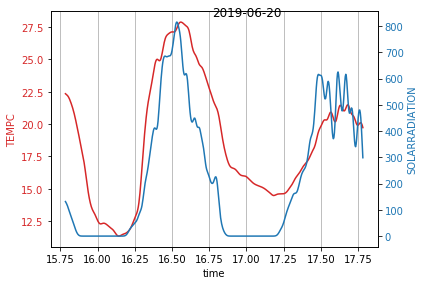

In [19]:
# simple line plot to see the correlation between solar radiation and temperature for 2 days
import datetime
day = 15
daylength = int(12*24)

i = 0
j = 3
print(varlist)

tstart = 19*12 - 2
timeday = (np.arange(0,nrows_) + tstart) / daylength
print(timeday[0:2])
timeday = timeday[daylength*day:daylength*(day+2)]
data_i = np.squeeze(norm_data[daylength*day:daylength*(day+2),i])
print(data_i[0:2])
data_j = np.squeeze(norm_data[daylength*day:daylength*(day+2),j])
print(data_j[0:2])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel(varlist[i], color=color)
ax1.plot(timeday, data_i, color=color, label = varlist[i])
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.grid(True, which='major')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(varlist[j], color=color)  # we already handled the x-label with ax1
ax2.plot(timeday, data_j, color=color, label = varlist[j])
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.suptitle(str(dates[day]),ha='left',va='top');

#  plt.plot(np.squeeze(hours[daylength*day:daylength*(day+2)]), 'k', label = "Hours")
# plt.xlabel('X')
# plt.ylabel('Y')
# legend = plt.legend(loc='lower right', shadow=True)
# frame = legend.get_frame()
# frame.set_facecolor('0.90')
#plt.show()

# Heat Map

Let's check the correlation between the fields of the datasets:

1. for the first week of the measurements,
2. for all the dataset.


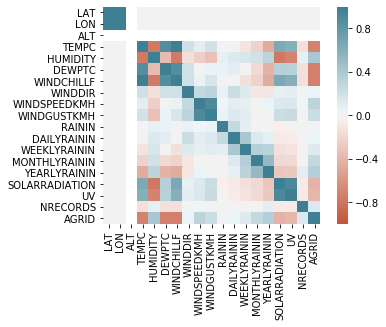

In [8]:
# read first n rows and columns
data_week = pd.read_csv(filename,skiprows=0, nrows = nrows_)
# create correlation matrix
corr = data_week.corr()
# plot correlation matrix
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);

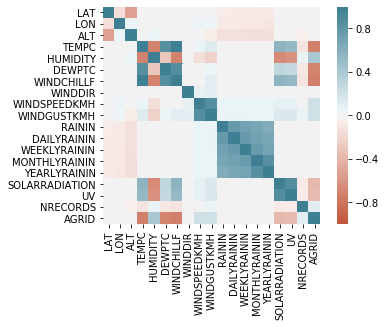

In [10]:
# read all data
data_all = pd.read_csv(filename,skiprows=0)
# create correlation matrix
corr = data_all.corr()
# plot correlation matrix for all the data
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);